In [105]:
# Python ≥3.7 is required
import sys
assert sys.version_info >= (3, 7)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥1.0.1 is required
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import pandas as pd

Deze dataset bevat data van cardiotocogrammen die gemaakt werden bij prenatale echo's. Door 3 experten werd een classificatie gedaan, zowel met betrekking tot het morfologisch patroon (CLASS) als met betrekking tot de toestand van de foetus (NSP). Dus zowel de kolom CLASS als de kolom NSP bevatten een 'score' die de 3 experten aan de data gaven.  
Daarom kan deze dataset gebruikt worden voor een 10-class of voor een 3-class classificatie.  


* LB - FHR-basislijn (slagen per minuut)    
* AC - aantal versnellingen per seconde  
* FM - aantal foetale bewegingen per seconde  
* UC - aantal baarmoedersamentrekkingen per seconde  
* DL - aantal lichtvertragingen per seconde  
* DS - aantal ernstige vertragingen per seconde  
* DP - aantal langdurige vertragingen per seconde  
* ASTV - percentage van de tijd met abnormale kortetermijnvariabiliteit  
* MSTV - gemiddelde waarde van kortetermijnvariabiliteit  
* ALTV - percentage van de tijd met abnormale langetermijnvariabiliteit  
* MLTV - gemiddelde waarde van langetermijnvariabiliteit  
* Width - breedte van FHR-histogram  
* Min - minimum van FHR-histogram  
* Max - Maximum van FHR-histogram  
* Nmax - aantal histogrampieken  
* Nzeros - aantal histogramnullen  
* Mode - histogrammodus  
* Mean - histogram gemiddelde  
* Median - histogram mediaan  
* Variance - histogramvariantie  
* Tendency - histogramtendens  
* CLASS - klassecode van de FHR (1 tot 10)
* NSP - klassecode van de toestand van de foetus (1 -> N=normaal; 2 -> S=verdacht (suspect); 3 -> P=pathologisch (= dit wijst op een ziekte))


Bron: https://archive.ics.uci.edu/ml/datasets/cardiotocography 

In [106]:
if 'google.colab' in str(get_ipython()):
    colab = True
    print ('You are running on Google Colab')
else:
    colab = False
    print ('You are not running on Google Colab')

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')

You are not running on Google Colab


In [107]:
if colab:
    df = pd.read_csv('/content/gdrive/MyDrive/DataEchos.csv', delimiter=";")
else:
    df = pd.read_csv('https://raw.githubusercontent.com/HOGENT-ML/course/main/datasets/DataEchos.csv', delimiter=";")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,CLASS,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,9,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,6,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,6,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,6,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,2,1.0


Geef algemene informatie over de  dataset (type van elke kolom, null waarden, ...)

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2126 non-null   float64
 1   AC        2126 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2126 non-null   float64
 6   DP        2126 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2126 non-null   float64
 11  Width     2126 non-null   float64
 12  Min       2126 non-null   float64
 13  Max       2126 non-null   float64
 14  Nmax      2126 non-null   float64
 15  Nzeros    2126 non-null   float64
 16  Mode      2126 non-null   float64
 17  Mean      2126 non-null   float64
 18  Median    2126 non-null   float64
 19  Variance  2126 non-null   float64
 20  Tendency  2126 non-null   floa

Is dit een scheve (skewed) dataset? Geef het aantal records voor NSP = 1, 2 en 3.

In [109]:
df["NSP"].value_counts()

NSP
1.0    1655
2.0     295
3.0     176
Name: count, dtype: int64

We willen de de classificatie doen op basis van NSP (en níet CLASS).  
Wat is X? Wat is y?

In [110]:
y = df["NSP"]
X = df.drop(['NSP', 'CLASS'], axis=1)

Wat is X_train, y_train, X_test, y_test?

In [111]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Wat zijn de numerieke kolommen in X?

In [112]:
numerical_ix = X.select_dtypes(include=['float64', 'int64']).columns
numerical_ix

Index(['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency'],
      dtype='object')

Geef de unieke waarden in NSP **gesorteerd** van klein naar groot.

In [113]:
nsp_values = np.sort(df["NSP"].unique())
nsp_values

array([1., 2., 3.])

Standardiseer de waarden in de numerieke kolommen.

In [114]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train_num = X_train[numerical_ix]
X_train_num_scaled= std_scaler.fit_transform(X_train_num)
X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num.columns, index=X_train_num.index)

X_test_num = X_test[numerical_ix]
X_test_num_scaled= std_scaler.transform(X_test_num)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns=X_test_num.columns, index=X_test_num.index)

In [115]:
X_train_num_scaled_df

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1233,-0.818907,-0.824976,-0.204261,1.218555,-0.637350,-0.064301,-0.268148,-0.859657,-0.262589,-0.367038,...,-0.500418,0.090151,-0.947494,-0.014607,-0.445313,-0.680274,-0.603307,-0.742903,-0.580514,-0.516697
480,0.692429,-0.824976,-0.204261,-1.159016,-0.637350,-0.064301,-0.268148,0.762723,-0.604484,1.233861,...,1.267146,-0.482204,1.975298,1.686204,-0.445313,0.222228,0.414302,0.281431,-0.545964,-0.516697
1111,-1.121174,-0.824976,-0.204261,-1.498669,-0.296949,-0.064301,-0.268148,-1.554963,0.535166,-0.532648,...,-0.807820,0.325826,-1.228531,-1.035093,-0.445313,-1.041275,-0.984911,-1.152636,-0.545964,-0.516697
1303,0.390162,0.464049,-0.204261,0.199596,0.043451,-0.064301,-0.268148,-0.627888,-0.490519,-0.532648,...,-0.193016,0.729841,0.794940,-0.014607,-0.445313,0.643396,0.859505,0.759453,-0.338667,-0.516697
861,0.893941,-0.051561,-0.204261,-0.140057,-0.637350,-0.064301,-0.268148,-0.048467,-0.718449,0.957844,...,-1.140840,1.335863,-0.273003,-1.035093,-0.445313,0.763729,0.859505,0.827742,-0.615063,-0.516697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,-0.315128,1.495268,-0.183561,-0.140057,-0.296949,-0.064301,-0.268148,0.299186,-0.034659,-0.532648,...,0.729192,-0.684211,0.457695,0.665717,-0.445313,0.402728,0.414302,0.418008,-0.096820,1.119029
1095,-1.020419,2.268683,-0.204261,-0.819363,-0.637350,-0.064301,-0.268148,-1.439078,0.991026,-0.532648,...,-0.474801,0.224822,-0.666456,-0.694931,-0.445313,-0.379440,-0.158104,-0.333169,-0.511415,-0.516697
1130,-1.121174,0.464049,-0.204261,-0.140057,1.064653,-0.064301,-0.268148,-1.554963,1.446887,-0.532648,...,0.703575,-1.121894,-0.329211,0.665717,-0.445313,-0.379440,-0.857710,-0.811192,0.421423,-0.516697
1294,-1.826465,-0.051561,-0.204261,1.218555,0.043451,-0.064301,1.383487,-1.323194,0.307236,-0.532648,...,0.959744,-0.751547,0.851147,-0.354769,2.444122,-0.259107,-0.794109,-0.606325,0.905117,-0.516697


Creëer een model gebruik maken van een Random Forest Classifier.  
Bepaal  de optimale waarden voor de parameters gebruik makend van GridSearchCV.  
Gebruik volgende parametercombinaties: 
- bootstrap = True, n_estimators = 3,10,30  max_features = 4,6,8
- bootstrap = False, n_estimators = 3,10  max_features = 2,3,4
Geef de gevonden optimale waarden voor de classifier.  
Geef de accuracy.

### RandomForestClassifier


In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameters = [{"bootstrap": [True], "n_estimators" : [3,10,30], "max_features": [4,6,8]},
              {"bootstrap": [False], "n_estimators" : [3,10], "max_features": [2,3,4]}]

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=5, scoring='accuracy', verbose=3)
clf.fit(X_train_num_scaled_df, y_train)

print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.915 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.894 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.900 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.938 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.921 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.921 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.912 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.929 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.929 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.935 total time=   0.0s
[CV 

[CV 2/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.926 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.935 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.929 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.947 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.921 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.891 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.897 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.921 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.932 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=6, n_estimators=10;, score=0.944 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=6, n_estimators=10;, sc

Stel de confusion matrix (zowel als numeriek cijferdiagramma en als genormaliseerd kleurdiagramma) op m.b.v. de TEST set en interpreteer. 

In [117]:
y_test_pred = clf.predict(X_test_num_scaled_df)
y_test_pred[:10]

array([1., 1., 1., 1., 1., 3., 1., 3., 2., 2.])

In [118]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_test, y_test_pred)
conf_mx

array([[325,   7,   1],
       [ 14,  44,   6],
       [  2,   1,  26]], dtype=int64)

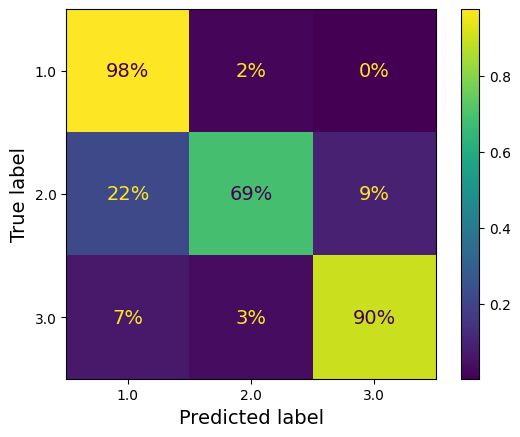

In [133]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, normalize='true', values_format='.0%')

Bekijk de confusion matrix goed. Hoewel de accuracy best ok lijkt, zijn de feitelijke resultaten niet goed.

Stel dat we NSP = 2 (Suspect) en 3 (Pathologisch) zonder onderscheid volledig samennemen als zijnde Positief (~ er is iets aan de hand) en NSP = 1 (Normaal) beschouwen als zijnde Negatief (~ er is niets aan de hand).  
Bereken en geef dan de precision op basis van de voorgaande numerieke confusion matrix.

In [120]:
precision = (conf_mx[1,1]+conf_mx[2,2]+conf_mx[1,2]+conf_mx[2,2]) / (conf_mx[1,1]+conf_mx[2,2]+conf_mx[1,2]+conf_mx[2,2]+conf_mx[0,1]+conf_mx[0,2])
print(precision)

0.9272727272727272


Bereken en geef dan de recall op basis van de voorgaande confusion matrix.

In [121]:
recall = (conf_mx[1,1]+conf_mx[2,2]+conf_mx[1,2]+conf_mx[2,2]) / (conf_mx[1,1]+conf_mx[2,2]+conf_mx[1,2]+conf_mx[2,2]+conf_mx[1,0]+conf_mx[2,0])
print(recall)

0.864406779661017


Wat is belangrijker in dit geval: precision of recall? Leg kort uit.

- recall, we willen zoveel mogelijk zieke fetusen detecteren

Wat is een mogelijke verklaring voor de slechte resultaten?

- te weining trainingdata

Teken de ROC curve voor de testset en bereken de AUC voor de binaire classifier waarbij negatief beschouwd wordt als NSP = 1 en positief als NSP = 2 of 3. Herwerk hiervoor de dataset. 
Aangezien Random Forest geen decision function heeft, moeten we gebruik maken van de functie `predict_proba()` op de classifier. 

In [122]:
# hertrainen als binaire classifier --> y-train aanpassen naar 2 waarden 1 en 2 (= 2+3)
# MSP = 1: negatief, NSP = 2: positief

In [123]:
y_train_23 = [1 if val == 1 else 2 for val in y_train.values]
y_train_23_series = pd.Series(y_train_23)
y_train_23_series.value_counts()

1    1322
2     378
Name: count, dtype: int64

In [124]:
y_test_23 = [1 if val == 1 else 2 for val in y_test.values]
y_test_23_series = pd.Series(y_test_23)
y_test_23_series.value_counts()

1    333
2     93
Name: count, dtype: int64

In [125]:
parameters = [{"bootstrap": [True], "n_estimators" : [3,10,30], "max_features": [4,6,8]},
              {"bootstrap": [False], "n_estimators" : [3,10], "max_features": [2,3,4]}]

rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=5, scoring='accuracy', verbose=3)
clf.fit(X_train_num_scaled_df, y_train_23_series)

print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.944 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.894 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.932 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.924 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=3;, score=0.944 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.932 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.924 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.935 total time=   0.0s


[CV 4/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.918 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=10;, score=0.968 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.953 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.950 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.938 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.941 total time=   0.0s
[CV 5/5] END bootstrap=True, max_features=4, n_estimators=30;, score=0.953 total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.944 total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.924 total time=   0.0s
[CV 3/5] END bootstrap=True, max_features=6, n_estimators=3;, score=0.918 total time=   0.0s
[CV 4/5] END bootstrap=True, max_features=6, n_estimators=3;, s

In [126]:
y_scores = clf.predict_proba(X_test_num_scaled_df)
y_scores[:10]

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.03333333, 0.96666667],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.1       , 0.9       ],
       [0.        , 1.        ]])

In [127]:
y_scores = y_scores[:,1]

In [128]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test_23_series, y_scores, pos_label=2)

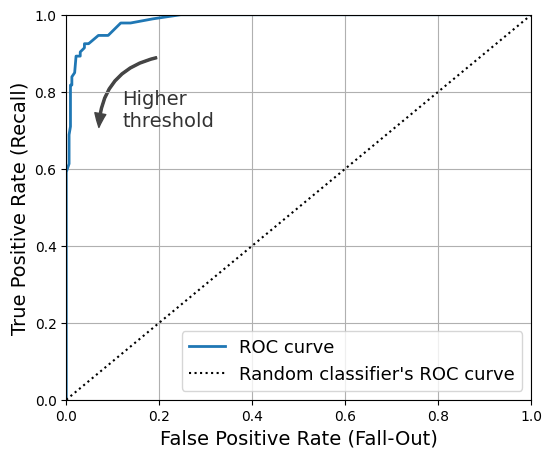

In [129]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

# extra code – just beautifies the figure with the curved arrow
plt.gca().add_patch(patches.FancyArrowPatch(
     (0.20, 0.89), (0.07, 0.70),
     connectionstyle="arc3,rad=.4",
     arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
     color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

In [131]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test_23_series, y_scores)

0.987309890535697